# Import libraries
Before you run this code for the first time, you will need to pip install the following libraries.
* tensorflow (version 2.7.0 recommended)
* tensorflow-nufft (version 0.6.0)
* mat73
* scipy
* matplotlib
* IPython

In [1]:
import os
from IPython.display import clear_output
import tensorflow as tf
import gc
import mat73
import numpy as np
import random as rn
import scipy.io as sio
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from matplotlib.colors import ListedColormap
from tensorflow import keras 
import tensorflow_nufft as tfft
from tensorflow.keras.layers import (InputSpec,ReLU,Conv1D,Conv2D,UpSampling1D,UpSampling2D,Concatenate,Dropout,Dense,Layer)
from tensorflow.keras.models import Model

# Make sure tensorflow is loaded properly
print(tf.__version__)
tf.keras.backend.clear_session();

2.7.0


# Scan Details

In [2]:
# Folder containing the raw data
raw_data_folder = '/nfs/turbo/umms-hamiljes/data/LRDIP_Example'

# Matrix size
N = 128     

# Grid images to 2x oversampled FOV, then crop to 1x FOV at the end
fovOS = 2 

# Trajectory/NUFFT setup

In [3]:
NN = int(fovOS*N)       # matrix size with 2x oversampling

# Set up the k-space sampling trajectory and density compensation function
X = mat73.loadmat(os.path.join(raw_data_folder,"trajectory.mat"))
k = X['k']             # undersampled k-space trajectory for each frame
w = X['w']             # density compensation function for each frame
kxall = X['kxall']     # fully sampled k-space trajectory
kyall = X['kyall']     
wi = X['wi']           # fully sampled density compensation function

if np.ndim(k) == 2:    # add an empty projection dimension if this is a single-shot trajectory
    k = k[:,None,:]
    w = w[:,None,:]

k = np.transpose(k,[1,0,2]) # Reshape to [projections, readout, frames
w = np.transpose(w,[1,0,2])
kxall = np.transpose(kxall) 
kyall = np.transpose(kyall)
wi = np.transpose(wi)
npacc, nread, Nex = k.shape
nproj = wi.shape[0]

# scale trajectory coordinates between -pi and +pi
kxu = np.real(k)
kyu = np.imag(k)
maxK = 0.5
kxu = kxu / maxK * np.pi
kyu = kyu / maxK * np.pi
maxK = np.max(np.sqrt(kxall**2 + kyall**2))
kxall = kxall / maxK * np.pi
kyall = kyall / maxK * np.pi

# Normalize the density comp function
for u in range(Nex):
    w[:,:,u] = w[:,:,u] / np.max(w[:,:,u])
w = w / npacc / nread
wi = wi / (np.max(wi) * nread * nproj)

# Now let's store the trajectory and DCF for each time frame
kspaceTraj_AllTimepoints = np.zeros((Nex,nread*npacc,2),dtype=float)
densityComp_AllTimepoints = np.zeros((Nex,nread*npacc),dtype=float)
for t in range(Nex):
    ktraju = np.stack((kxu[:,:,t].flatten(), kyu[:,:,t].flatten()), axis=0)
    ktraju = np.transpose(ktraju)
    kspaceTraj_AllTimepoints[t,:,:] = ktraju
    densityComp_AllTimepoints[t,:] = np.reshape(w[:,:,t],[npacc*nread,])
kspaceTraj_AllTimepoints = tf.cast(tf.convert_to_tensor(kspaceTraj_AllTimepoints),tf.float32)
densityComp_AllTimepoints = tf.cast(tf.convert_to_tensor(densityComp_AllTimepoints),tf.complex64)

kspaceTrajFull = np.stack((kxall.flatten(), kyall.flatten()), axis=0)
kspaceTrajFull = np.transpose(kspaceTrajFull)
kspaceTrajFull = tf.cast(tf.convert_to_tensor(kspaceTrajFull),tf.float32)
densityCompFull = np.reshape(wi,[nproj*nread,])
densityCompFull = tf.cast(tf.convert_to_tensor(densityCompFull),tf.complex64)

# Adjust scaling factors for NUFFT
for t in range(Nex):
    imtest = tf.ones((NN,NN),dtype=tf.complex64)
    ktest = tfft.nufft(imtest,kspaceTraj_AllTimepoints[t,:,:],grid_shape=(NN,NN),transform_type='type_2',fft_direction='forward')
    imnufft = tfft.nufft(ktest*densityComp_AllTimepoints[t,:],kspaceTraj_AllTimepoints[t,:,:],grid_shape=(NN,NN),transform_type='type_1',fft_direction='backward')
    scale = np.max(abs(imtest)) / np.max(abs(imnufft))
    w[:,:,t] *= scale

print("# of spiral arms per image: {}".format(npacc))
print("# of spiral readout points: {}".format(nread))
print("# of image frames:          {}".format(Nex))

2024-07-25 11:58:24.337538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 11:58:24.959553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43410 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:1e:00.0, compute capability: 8.6


# of spiral arms per image: 8
# of spiral readout points: 602
# of image frames:          128


# Load the undersampled k-space data

Loading coil sensitivity maps
Loading undersampled k-space data
Readout: 602
Proj:    8
Coils:   8
TRs:     128
Applying density compensation
Gridding undersampled images


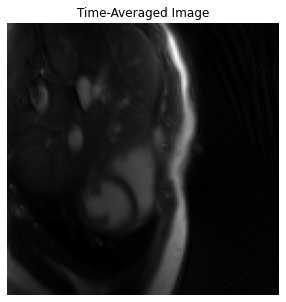

Normalizing data
Converting data to Tensorflow format


In [4]:
print("Loading coil sensitivity maps")
X = mat73.loadmat(os.path.join(raw_data_folder,"coilmap.mat"))
coilmaps = X['coilmap']
coilmaps = np.transpose(coilmaps,[2,0,1]) # [Ncoils, Ny, Nx]
nc = coilmaps.shape[0] # number of coils

print("Loading undersampled k-space data")
X = mat73.loadmat(os.path.join(raw_data_folder,"DATA.mat"))
DATA = X['DATA'] # this is the k-space data
del X; gc.collect();

if np.ndim(DATA) == 3: 
    if nc == 1: # add empty coil dimension if this is empty
        DATA = DATA[:,:,None,:]
    else:
        DATA = DATA[:,None,:,:] # add empty projection dimension if single-shot
elif np.ndim(DATA) == 2:
    DATA = DATA[:,None,None,:] # add empty coil and projection dimensions

nread,npacc,nc,Nex = DATA.shape     # [readout, projections, coils, frames]
print("Readout: {}".format(nread))
print("Proj:    {}".format(npacc))
print("Coils:   {}".format(nc))
print("TRs:     {}".format(Nex))

DATA = np.transpose(DATA)
DATA = np.reshape(DATA,[Nex,nc,npacc*nread])
DATA = np.transpose(DATA,[1,2,0]) # [coils, readxproj, frames]

print("Applying density compensation")
DATA *= np.transpose(densityComp_AllTimepoints)[None,:,:]

print("Gridding undersampled images")
imunder = np.zeros([Nex,NN,NN],dtype=complex)
imageSumCoils = np.zeros([nc,NN,NN],dtype=complex)
for t in range(Nex):
    kdata = tf.convert_to_tensor(DATA[:,:,t],tf.complex64) # k-space data for current frame [coils, projxread]
    ktraju = kspaceTraj_AllTimepoints[t,:,:]               # spiral trajectory for current frame
    image_temp = tfft.nufft( kdata, ktraju, grid_shape=(NN,NN),transform_type='type_1',fft_direction='backward') # coils, Y, X
    imunder[t,:,:] = np.sum(image_temp * np.conj(coilmaps),0) # coil combination
    imageSumCoils += image_temp

# As a QC check, let's display the time-averaged image. This will have motion blur. 
# But it is a quick way to make sure the image looks OK and we didn't make a silly mistake :)
imageAverage = np.sum(imunder,0)
plt.figure(figsize=(5,5));
plt.imshow(abs(imageAverage[NN//2-N//2:NN//2+N//2,NN//2-N//2:NN//2+N//2]),cmap='gray');
plt.axis('off'); plt.title('Time-Averaged Image'); plt.show();

print("Normalizing data")
maxValue = np.max(abs(imunder))
DATA /= maxValue # scale k-space data so that the max signal in the images is 1.
del ktraju, image_temp, kdata, imunder; gc.collect();

print("Converting data to Tensorflow format")
DATA = tf.convert_to_tensor(DATA,tf.complex64) # [coils, samplepoints, TRs]
DATA = tf.transpose(DATA,[0,2,1])  #[coils, TRs, samplepoints]
coilmaps = tf.convert_to_tensor(coilmaps,tf.complex64)

# LR-DIP Reconstruction

In [5]:
# subspace rank 
rankk                   = 64 #40

inputDepth              = 32             # feature maps in the input to the DIP (default: 32)
batch                   = 8              # number of frames in each minibatch (default: 8)
expw                    = 0.95           # takes exponential moving average of DIP output every epoch
dropoutPerc             = 0.1            # dropout level (number between 0-1) important for reducing noise. (Default: 0.1)
gradClip                = 0.01           # gradient clipping
numEpochs               = 2000           # total number of epochs
saveFreq                = 2000           #  set this equal to numEpochs to save only the final result; otherwise set to a smaller number to save results every X epochs
showFreq                = 50             # display images every 50 epochs

learnRates              = np.ones((numEpochs+1,)) * 0.001
learnRates[0:10]        = np.linspace(1e-4,learnRates[-1],10) # use a smaller learning rate for the first few epochs

# Results will be saved to this file
savename = "LRDIP"
savename += "_Rank{:.0f}".format(rankk)
print("Saving to: {}".format(savename))

# The temporal u-net has 5 encoding/decoding layers.
# Each encoding layer downsamples by a factor of 2.
# Here we make sure that the number of frames is divisible by 2^5 = 32.
# If not, just pad it with zeros before inputting to the u-net, and then remove
# the padded frames afterwards.
upper_frames = int( np.ceil(Nex/32) * 32 )
difference_frames = upper_frames - Nex
left_pad = difference_frames//2
right_pad = difference_frames - left_pad

nsteps = Nex // batch    # number of iterations per epoch (1 epoch = 1 pass over all time frames)

Saving to: LRDIP_Rank64


## Initialize the networks

In [6]:
class ReflectionPadding1D(Layer):
    def __init__(self, padding=(1,), data_format='channels_first', **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=3)]
        self.data_format = data_format
        super(ReflectionPadding1D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_first" configuration"""
        if self.data_format == 'channels_first':
            return (s[0], s[1], s[1] + 2 * self.padding[0])
        elif self.data_format == 'channels_last':
            return (s[0], s[1] + 2 * self.padding[0], s[2])

    def call(self, x, mask=None):
        h_pad = self.padding[0]
        if self.data_format == 'channels_first':
            return tf.pad(x, [[0,0], [0,0], [h_pad,h_pad] ], 'REFLECT')
        elif self.data_format == 'channels_last':
            return tf.pad(x, [[0,0], [h_pad,h_pad], [0,0] ], 'REFLECT')
        
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), data_format='channels_first', **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        self.data_format = data_format
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_first" configuration"""
        if self.data_format == 'channels_first':
            return (s[0], s[1], s[2] + 2 * self.padding[0], s[3] + 2 * self.padding[1])
        elif self.data_format == 'channels_last':
            return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        if self.data_format == 'channels_first':
            return tf.pad(x, [[0,0], [0,0], [h_pad,h_pad], [w_pad,w_pad] ], 'REFLECT')
        elif self.data_format == 'channels_last':
            return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad],[0,0] ], 'REFLECT')
        
class MyConv1D(Model):
    def __init__(self, myFilterSize=128, myKernelSize=(3,), myKernelStride=(1,), \
                 myDropoutType='Dropout', myDropoutFraction=0.05):
        super(MyConv1D, self).__init__()

        self.conv = Conv1D(filters=myFilterSize, kernel_size=myKernelSize, strides=myKernelStride, \
                           padding='valid', data_format='channels_first')
        self.reflect = ReflectionPadding1D(padding=(myKernelSize[0]//2,))
        self.drop = Dropout(myDropoutFraction) if myDropoutType == 'Dropout' else SpatialDropout2D(myDropoutFraction)
        self.act = ReLU()
        
    def call(self, x, trainingDrop=True):
            x = self.reflect(x)
            x = self.drop(x, trainingDrop)
            x = self.conv(x)
            x = self.act(x)
            return x        

class MyConv2D(Model):
    def __init__(self, myFilterSize=128, myKernelSize=(3, 3), myKernelStride=(1, 1), \
                 myDropoutType='Dropout', myDropoutFraction=0.05):
        super(MyConv2D, self).__init__()

        self.conv = Conv2D(filters=myFilterSize, kernel_size=myKernelSize, strides=myKernelStride, \
                           padding='valid', data_format='channels_first')
        self.reflect = ReflectionPadding2D(padding=(myKernelSize[0]//2,myKernelSize[1]//2))
        self.drop = Dropout(myDropoutFraction) if myDropoutType == 'Dropout' else SpatialDropout2D(myDropoutFraction)
        self.act = ReLU()
        
    def call(self, x, trainingDrop=True):
            x = self.reflect(x)
            x = self.drop(x, trainingDrop)
            x = self.conv(x)
            x = self.act(x)
            return x

class SpatialBasisNetwork(Model):
    def __init__(self, ups=5*[2], filters=5*[128], skips=5*[4]):
        super(SpatialBasisNetwork, self).__init__()

        # The output has 2 channels for the real and imaginary parts of the K subspace images.
        self.convOut = Conv2D(2*rankk, (1, 1), (1, 1),data_format='channels_first')

        self.ups = ups
        self.filters = filters
        self.skips = skips
        
        self.nlayers   = len(ups)
        self.encoder1  = {}
        self.encoder2  = {}
        self.decoder1  = {}
        self.decoder2  = {}
        self.skips     = {}
        self.upsample  = {}

        for i in range(self.nlayers):
            self.encoder1[i] = MyConv2D(filters[i],(3,3),(ups[i],ups[i]),'Dropout',dropoutPerc)
            self.encoder2[i] = MyConv2D(filters[i],(3,3),(1,1),'Dropout',dropoutPerc)
            self.skips[i]    = MyConv2D(skips[i],(1,1),(1,1),'Dropout',dropoutPerc)
            self.decoder1[i] = MyConv2D(filters[i],(3,3),(1,1),'Dropout',dropoutPerc)
            self.decoder2[i] = MyConv2D(filters[i],(3,3),(1,1),'Dropout',dropoutPerc)
            self.upsample[i]  = UpSampling2D( size=(ups[i],ups[i]),interpolation='nearest',data_format='channels_first')

    def call(self, x, trainingDrop=True):
      
        # Encoder
        xskips = {}
        for i in range(self.nlayers):
            xskips[i] = self.skips[i](x, trainingDrop)
            x = self.encoder1[i](x, trainingDrop) 
            x = self.encoder2[i](x, trainingDrop)

        # Decoder
        for i in range(self.nlayers-1,-1,-1):
            x = self.upsample[i](x)
            x = tf.concat([x,xskips[i]], axis=1)
            x = self.decoder1[i](x, trainingDrop)
            x = self.decoder2[i](x, trainingDrop)

        x = self.convOut(x) # [batch, 2*K, Y, X]
        x = tf.transpose(x,[0,2,3,1]) # [batch, X, Y, 2*K]
        return x
    
class TemporalBasisNetwork(Model):
    def __init__(self, ups=5*[2], filters=5*[128], skips=5*[4]):
        super(TemporalBasisNetwork, self).__init__()

        # The output has 2 channels for the real and imaginary parts of the K subspace images.
        self.convOut = Conv1D(2*rankk, (1,), (1,),data_format='channels_first')

        self.ups = ups
        self.filters = filters
        self.skips = skips
        
        self.nlayers   = len(ups)
        self.encoder1  = {}
        self.encoder2  = {}
        self.decoder1  = {}
        self.decoder2  = {}
        self.skips     = {}
        self.upsample  = {}

        for i in range(self.nlayers):
            self.encoder1[i] = MyConv1D(filters[i],(3,),(ups[i],),'Dropout',dropoutPerc)
            self.encoder2[i] = MyConv1D(filters[i],(3,),(1,),'Dropout',dropoutPerc)
            self.skips[i]    = MyConv1D(skips[i],(1,),(1,),'Dropout',dropoutPerc)
            self.decoder1[i] = MyConv1D(filters[i],(3,),(1,),'Dropout',dropoutPerc)
            self.decoder2[i] = MyConv1D(filters[i],(3,),(1,),'Dropout',dropoutPerc)
            self.upsample[i]  = UpSampling2D( size=(1,ups[i]),interpolation='nearest',data_format='channels_first')

    def call(self, x, trainingDrop=True):
      
        # Encoder
        xskips = {}
        for i in range(self.nlayers):
            xskips[i] = self.skips[i](x, trainingDrop)
            x = self.encoder1[i](x, trainingDrop) 
            x = self.encoder2[i](x, trainingDrop)

        # Decoder
        for i in range(self.nlayers-1,-1,-1):
            x = self.upsample[i](x[:,:,None,:])[:,:,0,:]
            x = tf.concat([x,xskips[i]], axis=1)
            x = self.decoder1[i](x, trainingDrop)
            x = self.decoder2[i](x, trainingDrop)

        x = self.convOut(x) 
        x = tf.transpose(x,[0,2,1])
        return x
    
modelU = SpatialBasisNetwork() # u-net that generates spatial basis images
modelV = TemporalBasisNetwork() # u-net that generates temporal basis function

# initialize the network inputs.
# these are initialized with random values and remain fixed during training
input_spatial = tf.random.uniform([1,inputDepth,NN,NN],minval = -1,maxval = 1)
input_temporal = tf.random.uniform([1,inputDepth,upper_frames],minval = -1,maxval = 1)


## Network Inference
Here we define a function that keeps track of the DIP output after every iteration.

In [7]:
Uavg = tf.zeros((N,N,rankk),dtype=tf.complex64) # the final spatial basis functions
Vavg = tf.zeros((rankk,Nex),dtype=tf.complex64) # the final temporal basis function

@tf.function
def TestNetwork(Uavg,Vavg):
    # spatial basis functions
    U = modelU(input_spatial,False)
    U = tf.cast(tf.complex(U[0,NN//2-N//2:NN//2+N//2,NN//2-N//2:NN//2+N//2,0:rankk],\
                           U[0,NN//2-N//2:NN//2+N//2,NN//2-N//2:NN//2+N//2,rankk:]),tf.complex64)

    # temporal basis functions
    V = modelV(input_temporal,False)
    V = tf.cast(tf.complex(V[0,left_pad:left_pad+Nex,0:rankk],V[0,left_pad:left_pad+Nex,rankk:]),tf.complex64)
    V = tf.transpose(tf.reshape(V,[Nex,rankk]))

    # take the exponential weighted average of the previous runs
    return U*(1-expw)+Uavg*expw, V*(1-expw)+Vavg*expw

# Let's time how long it takes to apply the network. The first run takes longer, so time it on the 2nd run
Uavg,Vavg = TestNetwork(Uavg,Vavg)
startTime = time.time()
Uavg,Vavg = TestNetwork(Uavg,Vavg)
inferenceTime = time.time() - startTime
print("Inference time = {:.1f} ms".format(inferenceTime*1000))


2024-07-25 11:58:31.863026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


Inference time = 9.8 ms


## Define the network training function

In [8]:
optimizer = tf.keras.optimizers.Adam( learnRates[0] )  # optimizer for the image reconstruction network

@tf.function
def trainDeepImagePrior(TRIndex_Batch, loss_scale=1.):

    # k-space trajectory (gather the time frames for the current minibatch)
    kspaceTrajBatch = tf.gather(kspaceTraj_AllTimepoints, TRIndex_Batch, axis=0)  # [timepoints,read,2]

    # density compensation function (gather the time frames for the current minibatch)
    densityCompBatch = tf.gather(densityComp_AllTimepoints, TRIndex_Batch, axis=0)  # [timepoints,read]

    # acquired (undersampled) spiral k-space data (gather the time frames for the current minibatch)
    acquiredData = tf.gather(DATA, TRIndex_Batch, axis=1)  # [coils, timepoints, read]

    with tf.GradientTape(persistent=True) as tape:

        # compute the spatial basis functions
        U = modelU(input_spatial,True)[0,:,:,:] # [y-pixels, x-pixels, 2*K]. Note: K is the subspace rank
        U = tf.cast(tf.complex(U[:,:,0:rankk],U[:,:,rankk:]),tf.complex64)
        U = tf.transpose(tf.reshape(tf.transpose(U),[rankk,NN*NN])) # [pixels, K]

        # compute the temporal basis functions
        V = modelV(input_temporal,True)[0,:,:] # [frames, 2*K]
        V = tf.cast(tf.complex(V[left_pad:left_pad+Nex,0:rankk],V[left_pad:left_pad+Nex,rankk:]),tf.complex64)
        V = tf.transpose(V) # [k, frames]
        V = tf.gather(V,TRIndex_Batch,axis=1) # k, batch
        
        # multiply U*V to get the dynamic images
        y = tf.reshape(tf.transpose(tf.matmul(U,V)),[batch,NN,NN]) # TRs, X, Y
        y = tf.transpose(y,[0,2,1]) # frames, Y, X
      
        # multiply by coil sensitivities
        y = y[None,:,:,:] * coilmaps[:,None,:,:] # image size: [coils, TRs, y-pixels, x-pixels]

        # forward NUFFT (image to spiral k-space)
        y = tfft.nufft(y, kspaceTrajBatch, transform_type='type_2',fft_direction='forward',tol=1e-14) # [coils, TRs, samplepoints]

        # multiply by density compensation function and scaling factor
        y = y * densityCompBatch[None,:,:]

        # compute MSE loss in kspace
        loss = tf.reduce_sum(abs(acquiredData-y)**2) * loss_scale
         
    gradients = tape.gradient(loss, modelU.trainable_variables + modelV.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 0.01)
    optimizer.apply_gradients(zip(gradients, modelU.trainable_variables + modelV.trainable_variables))

    return float(loss)


# It helps to scale the loss value to a reasonable range...
timerange = np.arange(0,Nex,1).astype('int') # list of time frames
lstep=0
t = timerange[lstep*batch:(lstep+1)*batch]
timeIndex = tf.cast(tf.convert_to_tensor(t),tf.int32)
currLoss = trainDeepImagePrior(timeIndex)
loss_scale = 100. / currLoss

# DIP Training

LRDIP_Rank64


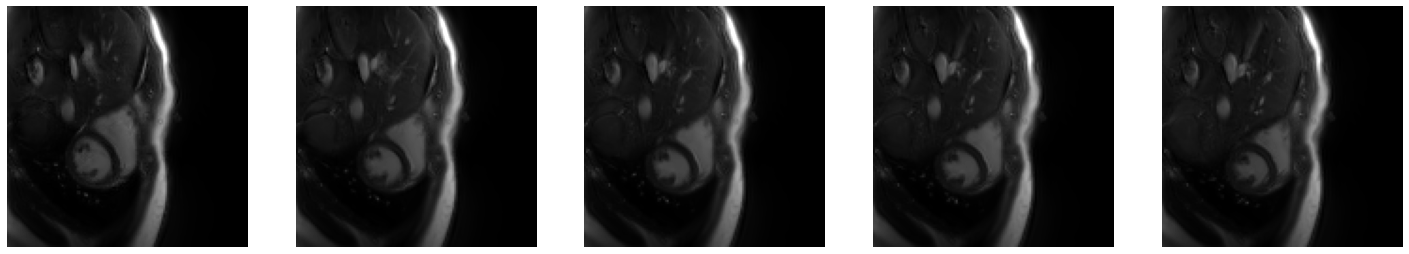

Saving...


In [9]:
startTime = time.time()
losses = []        # keep running list of the loss function value

for e in range(numEpochs + 1): 

    rn.shuffle(timerange) # shuffle the time frames
    runningLoss = 0

    optimizer.lr = learnRates[e]
    
    for lstep in range(nsteps): # Step through all image frames for training

        # Select time frames for the current minibatch
        t = timerange[lstep*batch:(lstep+1)*batch]
        timeIndex = tf.cast(tf.convert_to_tensor(t),tf.int32)
        
        # Compute the loss and update the DIP weights
        currLoss = trainDeepImagePrior(timeIndex, loss_scale)
        runningLoss += currLoss/nsteps # update the running loss
             
    losses.append(runningLoss)
    
    # update our final reconstruction
    Uavg,Vavg = TestNetwork(Uavg,Vavg)
    imNet = tf.transpose(tf.reshape(tf.transpose( tf.matmul(Uavg,Vavg) ),[Nex,N,N]))  # Multiply U*V
    
    
    # Display progress so far....
    elapsedTime = (time.time()-startTime) / 60.0 # elapsed time, in minutes
    
    if e % 5 == 0:
        print("Epoch {} / {}: Loss {:.6g}, {:.1f} minutes".format(e,numEpochs,losses[-1], elapsedTime));

    # Display images so far....
    if e % showFreq == 0:
        clear_output(wait=True)
        print(savename)

        framesToShow = np.linspace(0,Nex-1,5).astype('int') # display images at a few time points while the recon is running
        
        fs = 5
        plt.figure(figsize=(fs*5,fs*1));
        for lt in range(len(framesToShow)):
            t = framesToShow[lt]
            plt.subplot(1,len(framesToShow),lt+1); plt.imshow(abs(imNet[:,:,t]),cmap='gray',vmin=0,vmax=0.85*np.max(abs(imNet[:,:,t]))); plt.axis('off');
        plt.show();

    # Save results periodically...
    if (e % saveFreq == 0 and e>0):  
        print("Saving...")
        save_variables = {}
        save_variables['imNet'] = imNet.numpy()
        sio.savemat(os.path.join(raw_data_folder,savename + "_{}Epochs.mat".format(e)),save_variables)

# END